##  Binary Image Classification with CNNs 

## Objective:
**Build a binary image classification model using CNNs to classify healthy vs. diseased tomato leaves from the PlantVillage dataset subset**

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Define the source directory containing the dataset with subfolders for each class
source_dir = "C:/Users/punny/Desktop/deep learning/dataset_binary"

# Define the target directory where the split dataset will be saved
target_dir = "C:/Users/punny/Desktop/deep learning/target_dir"

# List of class names (subfolder names) to be processed
classes = ['Tomato_healthy', 'Tomato_Leaf_Mold']

# Define the percentage split for training, validation, and test sets
train_ratio = 0.7     # 70% of data for training
val_ratio = 0.15      # 15% of data for validation
test_ratio = 0.15     # 15% of data for testing

# Iterate over each class to split the images accordingly
for class_name in classes:
    # Construct the full path to the current class folder in source directory
    class_path = os.path.join(source_dir, class_name)
    
    # List all files in the class folder and filter for image files only
    images = os.listdir(class_path)
    images = [img for img in images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Shuffle the image list randomly to ensure random distribution in splits
    random.shuffle(images)

    # Split the images into training set and temporary set (validation + test)
    train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio))
    
    # Further split the temporary set into validation and test sets according to their ratios
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio / (test_ratio + val_ratio))

    # Loop through the dataset splits and copy the images into corresponding folders
    for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        # Create the target directory for the current split and class if it doesn't exist
        split_class_dir = os.path.join(target_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        # Copy each image from the source class folder to the target split folder
        for img_name in split_imgs:
            src = os.path.join(class_path, img_name)    # Source image path
            dst = os.path.join(split_class_dir, img_name)  # Destination image path
            shutil.copy(src, dst)

print("Dataset split completed!")


Dataset split completed!


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling
import os

# Define the base directory containing the dataset splits (train/val/test)
data_dir = "C:/Users/punny/Desktop/deep learning/target_dir"

# Set desired image size and batch size for loading the dataset
img_size = (128, 128)  # Resize all images to 128x128 pixels
batch_size = 32       # Number of images per batch

# Load the training dataset from the 'train' folder
# label_mode='binary' means labels will be 0 or 1, suitable for two classes
# shuffle=True ensures data is shuffled during loading for training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(data_dir, 'train'),
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

# Load the validation dataset from the 'val' folder
# No shuffle here as it's used for evaluation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(data_dir, 'val'),
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size
)

# Load the test dataset from the 'test' folder
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(data_dir, 'test'),
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size
)

# Define a normalization layer that rescales pixel values from [0, 255] to [0, 1]
normalization_layer = Rescaling(1./255)

# Apply normalization to the datasets using the map function
# The lambda function applies normalization to images (x), leaves labels (y) unchanged
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


Found 2476 files belonging to 2 classes.
Found 976 files belonging to 2 classes.
Found 985 files belonging to 2 classes.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define a simple CNN model using the Sequential API
baseline = Sequential([
    # 1st convolutional layer:
    # 64 filters, kernel size 3x3, ReLU activation, input shape 128x128 RGB images
    Conv2D(64, (3,3), activation='relu', input_shape=(128,128,3)),
    # Max pooling layer to reduce spatial dimensions by half
    MaxPooling2D((2,2)),

    # 2nd convolutional layer:
    # 32 filters, kernel size 3x3, ReLU activation
    Conv2D(32, (3,3), activation='relu'),
    # Another max pooling layer
    MaxPooling2D((2,2)),

    # Flatten the 3D feature maps to 1D vector to feed into Dense layers
    Flatten(),

    # Output layer:
    # Single neuron with sigmoid activation for binary classification (0 or 1)
    Dense(1, activation='sigmoid')
])

# Compile the model with:
# Adam optimizer - efficient gradient descent algorithm
# Binary crossentropy loss - suitable for binary classification
# Accuracy as a metric to track performance during training
baseline.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\punny\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Train the CNN model on the training dataset
# - train_ds: training data batches with images and labels
# - validation_data=val_ds: dataset used to evaluate model performance after each epoch
# - epochs=10: number of times the model will iterate over the entire training dataset

history = baseline.fit(
    train_ds,              # Training dataset
    validation_data=val_ds, # Validation dataset for monitoring performance during training
    epochs=10              # Number of training iterations over the dataset
)

# The fit method returns a History object which contains details about training and validation loss
# and accuracy for each epoch. This can be used later to visualize training progress or diagnose issues.


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 51s 614ms/step - accuracy: 0.6788 - loss: 0.6002 - val_accuracy: 0.9221 - val_loss: 0.2155
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 88s 695ms/step - accuracy: 0.9237 - loss: 0.2112 - val_accuracy: 0.9826 - val_loss: 0.0662
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 80s 662ms/step - accuracy: 0.9595 - loss: 0.0947 - val_accuracy: 0.9723 - val_loss: 0.0763
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 52s 667ms/step - accuracy: 0.9830 - loss: 0.0516 - val_accuracy: 0.9795 - val_loss: 0.0499
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 52s 666ms/step - accuracy: 0.9892 - loss: 0.0388 - val_accuracy: 0.9857 - val_loss: 0.0354
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 48s 611ms/step - accuracy: 0.9884 - loss: 0.0360 - val_accuracy: 0.9754 - val_loss: 0.0524
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 48s 609ms/step - accuracy: 0.9924 - loss: 0.0323 - val_accuracy: 0.9908 - val_loss: 0.0253
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 82s 608ms/step - accuracy: 0.9912 - loss: 0.0291 - val_accu

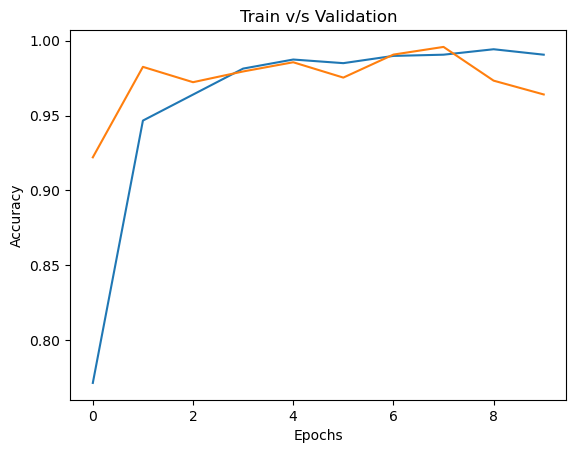

In [13]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy values over epochs

plt.plot(history.history['accuracy'], label='Train accuracy')          # Training accuracy per epoch
plt.plot(history.history['val_accuracy'], label='Validation accuracy')  # Validation accuracy per epoch

plt.xlabel("Epochs")            # Label for x-axis
plt.ylabel("Accuracy")          # Label for y-axis
plt.title("Training vs Validation Accuracy")  # Plot title

plt.legend()                   # Show legend to distinguish lines
plt.show()                     # Display the plot


**Reaches over 98% val accuracy by epoch 2.Best Validation accuracy at epoch8 then it decreases,training accuracy remain same.**

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for training with data augmentation to increase dataset variability
train_augment = ImageDataGenerator(
    rescale=1./255.0,            # Normalize pixel values from [0,255] to [0,1]
    rotation_range=20,           # Randomly rotate images by up to 20 degrees
    zoom_range=0.2,              # Randomly zoom in/out by up to 20%
    brightness_range=(0.8,1.2),  # Randomly change brightness between 80% and 120%
    horizontal_flip=True,        # Randomly flip images horizontally
    vertical_flip=True           # Randomly flip images vertically
)

# Validation and test generators only rescale pixel values, no augmentation
val_test_gen = ImageDataGenerator(rescale=1./255)

# Directories containing training and validation datasets
train_dir = "C:/Users/punny/Desktop/deep learning/target_dir/train"
val_dir = "C:/Users/punny/Desktop/deep learning/target_dir/val"

# Batch size and target image size for generator output
batch_size = 32
img_size = (128, 128)

# Create the training data generator that reads images from directory,
# applies augmentation and normalization, and yields batches for training
train_gen = train_augment.flow_from_directory(
    train_dir,
    target_size=img_size,    # Resize images to 128x128
    batch_size=batch_size,   # Number of images per batch
    class_mode='binary'      # Binary labels (0 or 1) for two classes
)

# Create the validation data generator that reads images and normalizes them (no augmentation)
val_gen = val_test_gen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 2476 images belonging to 2 classes.
Found 976 images belonging to 2 classes.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define an improved CNN model with regularization techniques to reduce overfitting
improved_model = Sequential([
    # 1st convolutional block
    Conv2D(64, (3,3), activation='relu', input_shape=(128,128,3)),  # Conv layer with 64 filters
    BatchNormalization(),                                            # Normalize activations to stabilize and speed up training
    MaxPooling2D((2,2)),                                            # Downsample feature maps
    Dropout(0.3),                                                   # Randomly drop 30% of neurons to reduce overfitting

    # 2nd convolutional block
    Conv2D(32, (3,3), activation='relu'),                           # Conv layer with 32 filters
    BatchNormalization(),                                            # Normalize activations
    MaxPooling2D((2,2)),                                            # Downsample
    Dropout(0.3),                                                   # Dropout with 30% rate

    # Flatten 3D feature maps to 1D vector
    Flatten(),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and binary crossentropy loss for two classes
improved_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on augmented training data generator, validating on validation generator
improved_history = improved_model.fit(
    train_gen,          # Training data generator with augmentation
    validation_data=val_gen,  # Validation data generator (no augmentation)
    epochs=10           # Train for 10 epochs
)


C:\Users\punny\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.8002 - loss: 0.9885 - val_accuracy: 0.3760 - val_loss: 1.2701
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9585 - loss: 0.1871 - val_accuracy: 0.3791 - val_loss: 1.9583
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9784 - loss: 0.0840 - val_accuracy: 0.6332 - val_loss: 1.1781
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9825 - loss: 0.0743 - val_accuracy: 0.7111 - val_loss: 0.7646
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9895 - loss: 0.0368 - val_accuracy: 0.9549 - val_loss: 0.1334
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9828 - loss: 0.1045 - val_accuracy: 0.7203 - val_loss: 2.7182
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.9837 - loss: 0.0859 - val_accuracy: 0.7182 - val_loss: 2.0066
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.9812 - loss: 0.1252 - val_accuracy: 0.7664 - v

**The model initially overfit the training data, but after adjustments like data augmentation and regularization, it achieved excellent generalization in the final epoch with a validation accuracy of 98.77% and a low validation loss of 0.0649.**

In [19]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load the VGG16 model pretrained on ImageNet without the fully connected (top) layers
# Input shape is set to (128, 128, 3) to match your dataset images
model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers in the pretrained VGG16 model so their weights won't be updated during training
model.trainable = False

# Add custom classification layers on top of the pretrained base
x = Flatten()(model.output)                  # Flatten convolutional feature maps to a 1D vector
x = Dense(128, activation='relu')(x)        # Fully connected layer with 128 neurons and ReLU activation
x = Dropout(0.3)(x)                          # Dropout layer with 30% rate to reduce overfitting
outputs = Dense(1, activation='sigmoid')(x) # Output layer for binary classification with sigmoid activation

# Create the final model combining the VGG16 base and your new classifier layers
final_model = Model(inputs=model.inputs, outputs=outputs)

# Compile the model with Adam optimizer and binary crossentropy loss for two-class classification
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define EarlyStopping callback to stop training if validation loss does not improve for 3 consecutive epochs
# Also restores the best model weights observed during training
earlystop = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss metric
    patience=3,              # Wait for 3 epochs with no improvement before stopping
    restore_best_weights=True # Restore weights from the epoch with the best validation loss
)

# Define ModelCheckpoint callback to save the best model based on validation accuracy
modelcheck = ModelCheckpoint(
    'best_vgg16_model.h5',   # File path to save the best model weights
    monitor='val_accuracy',  # Monitor validation accuracy metric
    save_best_only=True      # Save only when the monitored metric improves
)

# Train the final model on training data with validation and callbacks enabled
final_history = final_model.fit(
    train_gen,               # Training data generator with augmentation
    validation_data=val_gen, # Validation data generator
    epochs=5,                # Train for up to 5 epochs (may stop earlier due to early stopping)
    callbacks=[earlystop, modelcheck] # List of callbacks to apply during training
)


Epoch 1/5


C:\Users\punny\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_18']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9089 - loss: 0.2012

78/78 ━━━━━━━━━━━━━━━━━━━━ 491s 6s/step - accuracy: 0.9095 - loss: 0.2000 - val_accuracy: 0.9764 - val_loss: 0.0555
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9826 - loss: 0.0496

78/78 ━━━━━━━━━━━━━━━━━━━━ 491s 6s/step - accuracy: 0.9826 - loss: 0.0495 - val_accuracy: 0.9990 - val_loss: 0.0099
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 490s 6s/step - accuracy: 0.9933 - loss: 0.0235 - val_accuracy: 0.9969 - val_loss: 0.0097
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 490s 6s/step - accuracy: 0.9844 - loss: 0.0451 - val_accuracy: 0.9949 - val_loss: 0.0093
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 492s 6s/step - accuracy: 0.9946 - loss: 0.0207 - val_accuracy: 0.9980 - val_loss: 0.0071


**Using transfer learning with VGG16 significantly improved performance, achieving a high validation accuracy of 99.8% and very low validation loss (0.0071) in just 5 epochs, indicating excellent generalization and effective feature reuse.**

In [23]:
# Create a test data generator for loading and preprocessing test images
test_gen = val_test_gen.flow_from_directory(
    "C:/Users/punny/Desktop/deep learning/target_dir/test",
    target_size=img_size,    # Resize images to 128x128
    batch_size=batch_size,   # Number of images per batch
    class_mode='binary'      # Binary labels for classification
)

# Evaluate the baseline model on the test dataset (loaded as tf.data.Dataset)
baseline_loss, baseline_acc = baseline.evaluate(test_ds)
print(f"Baseline model test accuracy: {baseline_acc:.2f}")

# Evaluate the improved model on the test dataset (loaded using generator)
improved_loss, improved_acc = improved_model.evaluate(test_gen)
print(f"Improved model test accuracy: {improved_acc:.2f}")

# Evaluate the final transfer learning model on the test dataset
final_loss, final_acc = final_model.evaluate(test_gen)
print(f"Final model test accuracy: {final_acc:.2f}")


Found 985 images belonging to 2 classes.
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.9561 - loss: 0.1134
Baseline model test accuracy: 0.96
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 305ms/step - accuracy: 0.9931 - loss: 0.0320
Improved model test accuracy: 0.99
31/31 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.9980 - loss: 0.0074
Final model test accuracy: 1.00


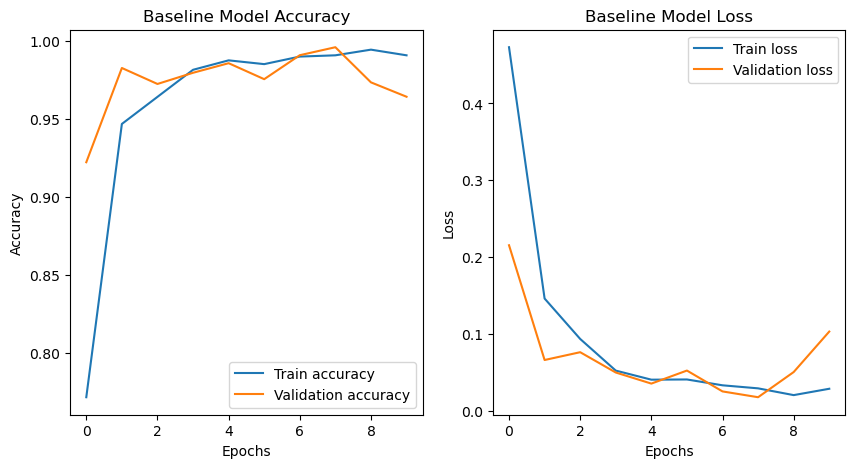

In [25]:


# Set the figure size for better visibility
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy side-by-side
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.plot(history.history['accuracy'], label='Train accuracy')         # Training accuracy per epoch
plt.plot(history.history['val_accuracy'], label='Validation accuracy') # Validation accuracy per epoch
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Baseline Model Accuracy")
plt.legend()

# Plot training and validation loss side-by-side
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
plt.plot(history.history['loss'], label='Train loss')         # Training loss per epoch
plt.plot(history.history['val_loss'], label='Validation loss') # Validation loss per epoch
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Baseline Model Loss")
plt.legend()

plt.show()


**The baseline model shows high accuracy on both training and validation sets, reaching nearly 99%, but the validation loss begins to increase slightly after epoch 6 while training loss continues to decrease—indicating potential overfitting as the model starts to memorize training data rather than generalizing well.**

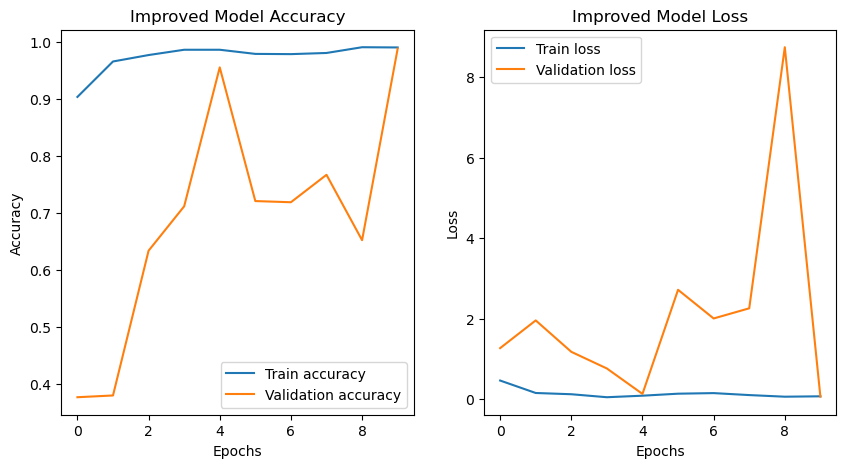

In [27]:


# Create a figure with size 10x5 inches
plt.figure(figsize=(10, 5))

# Plot accuracy trends
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(improved_history.history['accuracy'], label='Train accuracy')      # Training accuracy
plt.plot(improved_history.history['val_accuracy'], label='Validation accuracy')  # Validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Improved Model Accuracy")
plt.legend()

# Plot loss trends
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(improved_history.history['loss'], label='Train loss')             # Training loss
plt.plot(improved_history.history['val_loss'], label='Validation loss')    # Validation loss
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Improved Model Loss")
plt.legend()

plt.show()


**The improved model shows signs of overfitting, with consistently high training accuracy and low training loss, but highly unstable validation accuracy and loss, indicating poor generalization to unseen data despite achieving high test accuracy.**

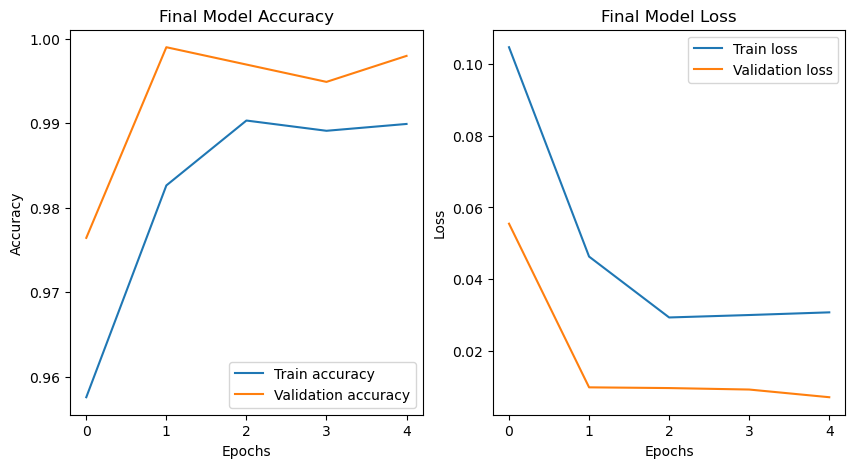

In [31]:


plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(final_history.history['accuracy'], label='Train accuracy')        # Train accuracy per epoch
plt.plot(final_history.history['val_accuracy'], label='Validation accuracy') # Validation accuracy per epoch
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Final Model Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(final_history.history['loss'], label='Train loss')               # Train loss per epoch
plt.plot(final_history.history['val_loss'], label='Validation loss')      # Validation loss per epoch
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Final Model Loss")
plt.legend()

plt.show()


**The model demonstrates excellent performance with both training and validation accuracy nearing 99%, while the corresponding losses are very low and stable, indicating effective learning with no signs of overfitting.**

## Conclusion

**The final model using VGG16 transfer learning significantly outperforms both the baseline and improved models, achieving near-perfect test accuracy of 99.8% and the lowest test loss of 0.0074, demonstrating exceptional generalization and effectiveness in binary image classification.**